# Training XGBoost

[Comprehencive tutorial](https://xgboost.readthedocs.io/en/latest/tutorials/index.html)

[Basic theory behind XGBoost](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)

XGBoost stands for “Extreme Gradient Boosting" and it is an algorithm to build an ensemble of decision trees. In comparison to other boosting schemes, XGBoost is particulary careful about the *complexity* of the individual trees.

 *[XGBoost] is developed with both deep consideration in terms of systems optimization and principles in machine learning,* say the developers.

## Hyperparameters

Taken from the [documentation](https://xgboost.readthedocs.io/en/stable/parameter.html) with minor edits

* `eta` [default=0.3, alias: `learning_rate`]

    *Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.*

    range: [0,1]

* `gamma` [default=0, alias: `min_split_loss`]

    *Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.*
    
    range: [0,∞]

* `max_depth` [default=6]

    *Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value.*

    range: [0,∞]

* `min_child_weight` [default=1]

    *Target purity of the leaves. Terminates the branch growth. The larger `min_child_weight` is, the more conservative the algorithm will be.*

    range: [0,∞]

* `subsample` [default=1]

    *Portion of the training data that's subsampled on every boosting iteration. Helps to prevent overfitting.*
    
    *There are other subsampling parameters*

    range: (0,1]

* `labmda` [default=1, alias: reg_lambda]

    *L2 regularization term on weights. Increasing this value will make model more conservative.*

    range: [0,∞]

* `alpha` [default=0, alias: reg_alpha]

    *L1 regularization term on weights. Increasing this value will make model more conservative.*

    range: [0,∞]

* `tree_method string` [default= auto]

    *The tree construction algorithm used in XGBoost.* 
    
    *"Greediness" (how thorough do we search for the optimal solution):*
    
    `hist`=`auto` < `approx` < `exact`

    Choices:

    - `exact`: Exact greedy algorithm. Enumerates all split candidates.

    - `approx`: Approximate greedy algorithm using quantile sketch and gradient histogram.

    - `hist`: Faster histogram optimized approximate greedy algorithm.

    - `auto`: Same as the `hist` tree method.

    - Define a custom method with other hyperparameters

* `grow_policy` [default = depthwise]

    *Controls a way new nodes are added to the tree.*

    *Only for tree_method = hist or approx.*

    Choices:

    - `depthwise`: split at nodes closest to the root.

    - `lossguide`: split at nodes with highest loss change.

* `max_leaves` [default=0]

    *Maximum number of nodes to be added. Not used by exact tree method.*

* `num_parallel_tree`, [default=1]

    *Number of parallel trees constructed during each iteration. This option is used to support boosted random forest.*


## Settings

* `objective` [default=reg:squarederror]

    For binary classifications: 
    - `binary:logistic`: logistic regression for binary classification, output probability

    - `binary:logitraw`: logistic regression for binary classification, output score before logistic transformation

    - `binary:hinge`: hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.

* `eval_metric` [default according to objective]

    *Evaluation metrics for validation data, a default metric will be assigned according to objective (`rmse` for regression, and `logloss` for classification, etc.)*

    *Interesting alternatives:*
    - `auc` 
    - `aucpr` - area under the precision - recall curve
    
* `seed` [default=0]

   *The random seed.*

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from pickle import load, dump
from eval_metrics_katja import *
import configparser

cfg = configparser.ConfigParser()
cfg.read_file(open('../config.cfg'))

# Load the data

Load the data, do the train-test split

In [22]:
pd.set_option('display.max_columns', 999)

In [3]:
cat_features = cfg.get('PREPROCESSING', 'cat_features').split()
num_features = cfg.get('PREPROCESSING', 'num_features').split()

In [23]:
df = pd.read_csv('../data/merged_df.csv', usecols=cat_features+num_features+['target'])
df

,district,client_id,client_catg,region,creation_date,target,acc_creation_year,acc_creation_month,acc_creation_weekday,total_consum_lvl1_mean,total_consum_lvl2_mean,total_consum_lvl3_mean,total_consum_lvl4_mean,total_consum_lvl1_std,total_consum_lvl2_std,total_consum_lvl3_std,total_consum_lvl4_std,total_consum_lvl1_max,total_consum_lvl2_max,total_consum_lvl3_max,total_consum_lvl4_max,total_consum_lvl1_min,total_consum_lvl2_min,total_consum_lvl3_min,total_consum_lvl4_min,elec_consum_lvl1_mean,elec_consum_lvl2_mean,elec_consum_lvl3_mean,elec_consum_lvl4_mean,elec_consum_lvl1_std,elec_consum_lvl2_std,elec_consum_lvl3_std,elec_consum_lvl4_std,elec_consum_lvl1_max,elec_consum_lvl2_max,elec_consum_lvl3_max,elec_consum_lvl4_max,elec_consum_lvl1_min,elec_consum_lvl2_min,elec_consum_lvl3_min,elec_consum_lvl4_min,gaz_consum_lvl1_mean,gaz_consum_lvl2_mean,gaz_consum_lvl3_mean,gaz_consum_lvl4_mean,gaz_consum_lvl1_std,gaz_consum_lvl2_std,gaz_consum_lvl3_std,gaz_consum_lvl4_std,gaz_consum_lvl1_max,gaz_consum_lvl2_max,gaz_consum_lvl3_max,gaz_consum_lvl4_max,gaz_consum_lvl1_min,gaz_consum_lvl2_min,gaz_consum_lvl3_min,gaz_consum_lvl4_min,elec_tarif_count,elec_tarif_min,elec_tarif_max,gaz_tarif_count,gaz_tarif_min,gaz_tarif_max
0,60,0,11,101,1994-12-31,0.0,1994,12,5,352.400000,10.571429,0.000000,0.000000,310.343472,43.568935,0.000000,0.000000,1200,186,0,0,38,0,0,0,352.400000,10.571429,0.000000,0.000000,310.343472,43.568935,0.000000,0.000000,1200.0,186.0,0.0,0.0,38.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,11.0,11.0,0.0,0.0,0.0
1,69,1,11,107,2002-05-29,0.0,2002,5,2,557.540541,0.000000,0.000000,0.000000,197.935960,0.000000,0.000000,0.000000,1207,0,0,0,190,0,0,0,557.540541,0.000000,0.000000,0.000000,197.935960,0.000000,0.000000,0.000000,1207.0,0.0,0.0,0.0,190.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,11.0,11.0,0.0,0.0,0.0
2,62,10,11,301,1986-03-13,0.0,1986,3,3,798.611111,37.888889,0.000000,0.000000,513.841374,160.748942,0.000000,0.000000,2400,682,0,0,188,0,0,0,798.611111,37.888889,0.000000,0.000000,513.841374,160.748942,0.000000,0.000000,2400.0,682.0,0.0,0.0,188.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,11.0,11.0,0.0,0.0,0.0
3,69,100,11,105,1996-07-11,0.0,1996,7,3,1.200000,0.000000,0.000000,0.000000,3.607011,0.000000,0.000000,0.000000,15,0,0,0,0,0,0,0,1.200000,0.000000,0.000000,0.000000,3.607011,0.000000,0.000000,0.000000,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,11.0,11.0,0.0,0.0,0.0
4,62,1000,11,303,2014-10-14,0.0,2014,10,1,663.714286,104.857143,117.357143,36.714286,224.831365,167.155320,289.433294,105.421081,800,400,800,382,124,0,0,0,663.714286,104.857143,117.357143,36.714286,224.831365,167.155320,289.433294,105.421081,800.0,400.0,800.0,382.0,124.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,11.0,11.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135488,62,99995,11,304,2004-07-26,0.0,2004,7,0,1.957746,0.000000,0.000000,0.000000,16.496265,0.000000,0.000000,0.000000,139,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.088235,0.0,0.0,0.0,23.838303,0.0,0.0,0.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,11.0,11.0,34.0,40.0,40.0
135489,63,99996,11,311,2012-10-25,0.0,2012,10,3,185.853659,0.756098,0.000000,0.000000,200.935258,4.841387,0.000000,0.000000,800,31,0,0,0,0,0,0,309.700000,1.550000,0.000000,0.000000,223.228252,6.931811,0.000000,0.000000,800.0,31.0,0.0,0.0,3.0,0.0,0.0,0.0,67.904762,0.0,0.0,0.0,58.865869,0.0,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,11.0,11.0,21.0,40.0,40.0
135490,63,99997,11,

In [4]:
X = df[cat_features + num_features]
y = df.target

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    random_state=cfg.getint('GENERAL', 'RandomSeed'))

# Training

Loading the pipeline

In [6]:
pipe_name = cfg.get('XGBOOST', 'name')
pipe = load(open(f'../pipelines/{pipe_name}.pkl', 'rb'))

pipe

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['elec_tarif_count',
                                                                                'gaz_tarif_count',
                                                                                'total_consum_lvl1_mean',
                                                                                'total_consum_lvl2_mean',
                                                                                'total_consum_lvl3_mean',
                                                                                'total_consum_lvl4_mean']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('1hot',
                                                                                                OneHotEncoder(handle_unk...
                                                            min_split_loss=0,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_jobs=-1,
                   param_distributions={'xgboost__alpha': [0.0, 0.1, 1.0, 10.0],
                                        'xgboost__grow_policy': ['depthwise',
                                                                 'lossguide'],
                                        'xgboost__lambda': [0.0, 0.1, 1.0,
                                                            10.0],
                                        'xgboost__learning_rate': [0.2, 0.4,
                                                                   0.5]},
                   scoring='f1_weighted', verbose=1)

Training the XGBoost models

In [7]:
pipe.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['elec_tarif_count',
                                                                                'gaz_tarif_count',
                                                                                'total_consum_lvl1_mean',
                                                                                'total_consum_lvl2_mean',
                                                                                'total_consum_lvl3_mean',
                                                                                'total_consum_lvl4_mean']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('1hot',
                                                                                                OneHotEncoder(handle_unk...
                                                            min_split_loss=0,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_jobs=-1,
                   param_distributions={'xgboost__alpha': [0.0, 0.1, 1.0, 10.0],
                                        'xgboost__grow_policy': ['depthwise',
                                                                 'lossguide'],
                                        'xgboost__lambda': [0.0, 0.1, 1.0,
                                                            10.0],
                                        'xgboost__learning_rate': [0.2, 0.4,
                                                                   0.5]},
                   scoring='f1_weighted', verbose=1)

In [13]:
model = pipe.best_estimator_
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['elec_tarif_count',
                                                   'gaz_tarif_count',
                                                   'total_consum_lvl1_mean',
                                                   'total_consum_lvl2_mean',
                                                   'total_consum_lvl3_mean',
                                                   'total_consum_lvl4_mean']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['district', 'reg...
                               feature_types=None, gamma=None,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints=None, lambda=1.0,
                               learning_rate=0.5, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=0, min_child_weight=None,
                               min_split_loss=0, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, ...))])

Save the model

In [ ]:
model_name = 'xgb_1'

In [14]:
dump(model, open(f'../models/{model_name}.pkl', 'wb'))

# Evaluation

(Re)load the model

In [ ]:
model_name = 'xgb_2'

In [15]:
model = load(open(f'../models/{model_name}.pkl', 'rb'))

Make predictions

In [16]:
y_pred = model.predict(X_test)
#y_proba = model.predict_proba(X_test)
y_score = calculate_y_score(model, X_test)

Recall: 0.03 Precision: 0.32 ROC AUC: 0.72 F-beta: 0.28
                Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     31982
         1.0       0.32      0.03      0.05      1892

    accuracy                           0.94     33874
   macro avg       0.63      0.51      0.51     33874
weighted avg       0.91      0.94      0.92     33874



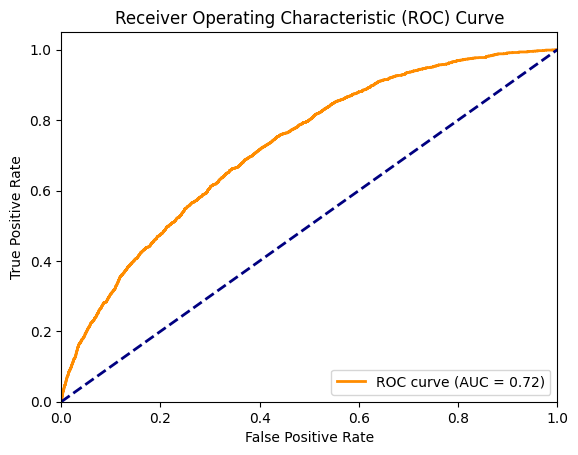

In [17]:
evaluate_one_model(predictions=y_pred,
                   probabilities=y_score,
                   y_test=y_test,
                   )